In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
import numpy as np
import pandas as pd
from math import log
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [597]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv', index_col=False)

In [598]:
def process_df(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
    df = df.drop('Color', axis=1)
    df['Rating'] = df['Rating'].str.replace(',', '.')
    df['Rating'] = df['Rating'].astype(float)

    # if is_train:
    #     df['Brand weight'] = ""
    #     for category in df['Brand'].unique():
    #         total_rating = df.loc[df['Brand'] == category].count() / df.shape[0]
    #         df.loc[df['Brand'] == category, 'Brand weight'] = total_rating

    df = df.drop([
        'Name',
        'Category',
        # 'Min price',
        # 'Max price',
        # 'Average price',
        'full_category',
        'Seller',
        'Base price'
    ], axis=1)
    df['Days in stock/sales'] = df['Days with sales'].div(df['Days in stock'], axis=0).apply(
        lambda x: 1.0 if x >= 1.0 else x)
    df['Comments-Rating'] = df['Comments'] * df['Rating']
    df['Rating-Days-Comments'] = np.exp(df['Days with sales']) * df['Rating'] * df['Comments']
    df['Price difference'] = np.exp(df['Average price'].fillna(0).div(df['Final price'], axis=0)) ** 3
    df['Min max price diff'] = np.log10((df['Max price'] - df['Final price']).apply(lambda x: 1 if x == 0 else x)) ** 3
    df = df.drop(['Average price', 'Max price', 'Min price'], axis=1)

    return df.dropna() if is_train else df

In [599]:
origin_train = process_df(train, True)
origin_test = process_df(test, False)
origin_test.drop('Id', axis=1, inplace=True)

origin_test

,Brand,Comments,Final price,Days in stock,Days with sales,Rating,Basic Sale,Basic Sale Price,Days in stock/sales,Comments-Rating,Rating-Days-Comments,Price difference,Min max price diff
0,Majava,2.0,277.0,16.0,14,0.0,50.0,360.0,0.875000,0.0,0.000000e+00,17.885865,0.000000
1,Beon,5.0,2211.0,7.0,8,3.0,40.0,2664.0,1.000000,15.0,4.471437e+04,20.085537,0.000000
2,NEOLUX,19.0,490.0,31.0,22,5.0,30.0,490.0,0.709677,95.0,3.405667e+11,18.535758,0.000000
3,CENTEK,2.0,807.0,31.0,0,4.0,15.0,807.0,0.000000,8.0,8.000000e+00,1.000000,0.000000
4,HUAYU,3.0,426.0,31.0,5,5.0,3.0,426.0,0.161290,15.0,2.226197e+03,20.085537,1.505565
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,INDESIT,0.0,17803.0,31.0,3,0.0,23.0,19781.0,0.096774,0.0,0.000000e+00,20.085537,42.065928
10737,Gelberk,8.0,897.0,12.0,9,4.0,54.0,1150.0,0.750000,32.0,2.592987e+05,20.085537,0.000000
10738,Rowenta,15.0,1565.0,31.0,29,3.0,46.0,1565.0,0.935484,45.0,1.769100e+14,27.715964,30.522144
10739,EREMON,0.0,2752.0,11.0,2,0.0,20.0,3440.0,0.181818,0.0,0.000000e+00,20.085537,0.000000


In [600]:
origin_test.shape

(10741, 13)

In [601]:
origin_train.shape

(23338, 14)

In [602]:
def get_histogram(df: pd.DataFrame, name: str):
    vals = sorted(df[name].unique())

    bins = 1 + log(len(vals), 2)
    min = vals[0]
    max = vals[len(vals) - 1]
    length = (max - min) / bins

    intervals = [min + length * i for i in range(int(bins) + 1)]
    plt.hist(vals, histtype='stepfilled', bins=intervals)

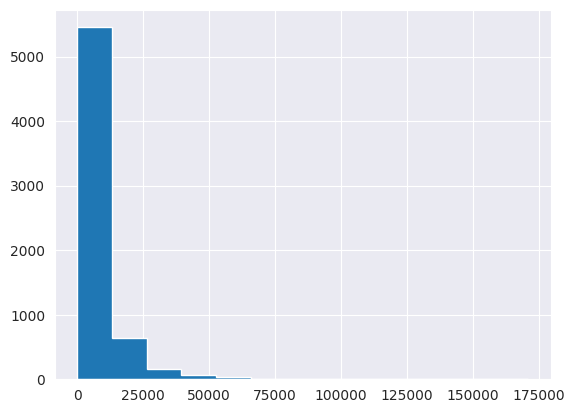

In [603]:
get_histogram(origin_train, 'Final price')

In [604]:
features = origin_train.drop(['Sales'], axis=1)
target = origin_train['Sales']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

In [605]:
# def clear_column_from_extremes(data_frame: pd.DataFrame, col_name: str):
#     column = data_frame[col_name]
#     q = np.nanquantile(column, q=[0.25, 0.75])
#     low = q[0] - 1.5 * (q[1] - q[0])
#     high = q[1] + 1.5 * (q[1] - q[0])
#
#     for index, row in data_frame.iterrows():
#         aux = data_frame[col_name].loc[index]
#         if not (low <= aux < high) and np.isnan(data_frame["G_total"].loc[index]):
#            data_frame.drop(index, inplace=True)
#     return data_frame

In [606]:
def delete_nan_cols(df: pd.DataFrame):
    new_df = df
    nan_count_series = new_df.isna().sum()
    column_size = new_df.shape[0]

    for i, v in nan_count_series.items():
        if (v / column_size) * 100 > 45:
            print(f'Deleted {i}')
            new_df = new_df.drop(i, axis=1)

    return new_df

In [607]:
print(len(list(delete_nan_cols(X_train).columns.values)))
print(len(list(X_train.columns.values)))

13
13


In [608]:
label_encoder = LabelEncoder()

In [609]:
def categorize_columns(data: pd.DataFrame):
    categorical_columns = data.columns[data.dtypes == 'object']
    print(categorical_columns)

    for column in categorical_columns:
        data[column] = label_encoder.fit_transform(data[column])

In [610]:
categorize_columns(X_train)
categorize_columns(X_test)
categorize_columns(origin_test)
categorize_columns(origin_train)

Index(['Brand'], dtype='object')
Index(['Brand'], dtype='object')
Index(['Brand'], dtype='object')
Index(['Brand'], dtype='object')


<AxesSubplot: >

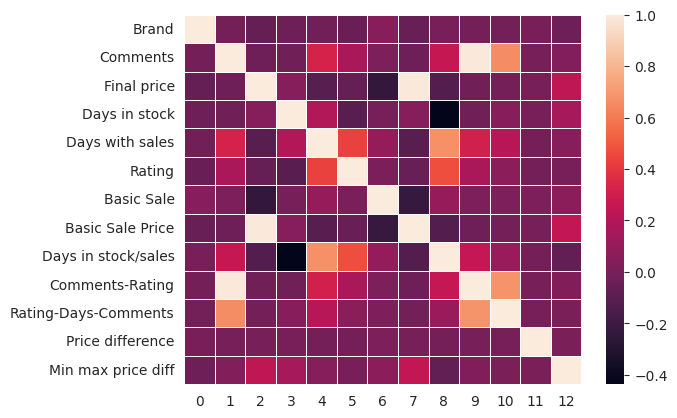

In [611]:
cor = X_train.corr()
plt.clf()
sns.heatmap(cor, xticklabels=range(X_train.shape[1]), yticklabels=1, linewidths=.5)

In [612]:
feature_model = RandomForestRegressor(verbose=999, max_depth=None, random_state=42)

feature_model.fit(X_train, y_train)
print(feature_model.feature_importances_, feature_model.feature_names_in_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining: 

In [574]:
# params = {
#     'learning_rate': [0.01, 0.1, 0.2, 0.5, 0.1],
#     'min_samples_leaf': [4, 5, 6],
#     'loss': ['absolute_error'],
#     'l2_regularization': [0.1, 0.2, 0.05],
#     'max_bins': [50, 100, 150],
#     'max_depth': [None],
#     'max_leaf_nodes': [None, 5, 6, 8],
#     'validation_fraction': [0.01, 0.1, 0.2]
# }
#
# boost_model = GridSearchCV(
#     HistGradientBoostingRegressor(max_iter=1000, max_bins=100, random_state=42),
#     params, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=999
# )
#
# boost_model.fit(X_train, y_train)
# # learning_rate=0.01, verbose=999, max_depth=None, min_samples_leaf=30, max_iter=1000, loss='absolute_error', l2_regularization=0.02, max_bins=100, validation_fraction=0.02, random_state=42
#
# # learning_rate=0.01, verbose=999, max_depth=None, min_samples_leaf=4, max_iter=1000, loss='absolute_error', l2_regularization=0.2, max_bins=100, validation_fraction=0.01, random_state=42
#
# # 'l2_regularization': 0.05,
# #  'learning_rate': 0.01,
# #  'loss': 'absolute_error',
# #  'max_bins': 150,
# #  'max_depth': None,
# #  'max_leaf_nodes': None,
# #  'min_samples_leaf': 6,
# #  'validation_fraction': 0.2

In [575]:
# boost_model.best_params_

In [576]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
#
# pipeline = make_pipeline(
#     PolynomialFeatures(degree=3),
#     SelectKBest(mutual_info_regression, k=10)
# )
#
# poly_features = pipeline.fit_transform(X_train, y_train)
# poly_features

In [653]:
from sklearn.ensemble import AdaBoostRegressor

forest_model = RandomForestRegressor(n_estimators=100, criterion='absolute_error', verbose=999, min_samples_leaf=20,
                                     min_samples_split=20,
                                     random_state=42, n_jobs=-1)
boost_model = AdaBoostRegressor(estimator=forest_model, n_estimators=3, loss="linear", random_state=42)

# boost_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
building tree 34 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elap

AdaBoostRegressor(estimator=RandomForestRegressor(criterion='absolute_error',
                                                  min_samples_leaf=20,
                                                  min_samples_split=20,
                                                  n_jobs=-1, random_state=42,
                                                  verbose=999),
                  n_estimators=3, random_state=42)

In [671]:
from sklearn.ensemble import StackingRegressor

hist_boost_model = lambda: HistGradientBoostingRegressor(learning_rate=0.01, verbose=999, max_depth=None, min_samples_leaf=4,
                                                 max_iter=10000, loss='absolute_error', l2_regularization=0.02,
                                                 max_bins=100,
                                                 validation_fraction=0.01, random_state=46)

# hist_boost_model.fit(X_train, y_train)
estimators = [('1', hist_boost_model()), ('2', RandomForestRegressor(n_estimators=100, criterion='absolute_error', verbose=999, min_samples_leaf=20,
                                     min_samples_split=20, n_jobs=-1))]
stack = StackingRegressor(estimators=estimators, final_estimator=HistGradientBoostingRegressor(random_state=42))

stack.fit(X_train, y_train)

Binning 0.002 GB of training data: 0.060 s
Binning 0.000 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/10000] 1 tree, 31 leaves, max depth = 9, train loss: 42.16146, val loss: 34.38025, in 0.005s
[2/10000] 1 tree, 31 leaves, max depth = 8, train loss: 42.07029, val loss: 34.29773, in 0.029s
[3/10000] 1 tree, 31 leaves, max depth = 8, train loss: 41.97906, val loss: 34.21458, in 0.045s
[4/10000] 1 tree, 31 leaves, max depth = 9, train loss: 41.88960, val loss: 34.13339, in 0.017s
[5/10000] 1 tree, 31 leaves, max depth = 10, train loss: 41.80104, val loss: 34.05314, in 0.016s
[6/10000] 1 tree, 31 leaves, max depth = 8, train loss: 41.71412, val loss: 33.97356, in 0.006s
[7/10000] 1 tree, 31 leaves, max depth = 8, train loss: 41.61907, val loss: 33.88538, in 0.008s
[8/10000] 1 tree, 31 leaves, max depth = 8, train loss: 41.52499, val loss: 33.79814, in 0.006s
[9/10000] 1 tree, 31 leaves, max depth = 8, train loss: 41.43185, val loss: 33.71182, in 0.006s
[10/10000] 1 t

StackingRegressor(estimators=[('1',
                               HistGradientBoostingRegressor(l2_regularization=0.02,
                                                             learning_rate=0.01,
                                                             loss='absolute_error',
                                                             max_bins=100,
                                                             max_iter=10000,
                                                             min_samples_leaf=4,
                                                             random_state=46,
                                                             validation_fraction=0.01,
                                                             verbose=999)),
                              ('2',
                               RandomForestRegressor(criterion='absolute_error',
                                                     min_samples_leaf=20,
                                                     min_samples_split=20,
                                                     n_jobs=-1, verbose=999))],
                  final_estimator=HistGradientBoostingRegressor(random_state=42))

In [672]:
# SelectKBest(mutual_info_regression, k=9).fit_transform(X_train, y_train)

In [673]:
def score(predicted: np.ndarray, expected: np.ndarray):
    def smape(A, F):
        return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

    print(f'Smape: {smape(expected, predicted)}')
    print(f'R2: {r2_score(expected, predicted)}')
    print(f'RMSE: {mean_squared_error(expected, predicted)}')

In [674]:
def postprocess(output: np.ndarray) -> np.ndarray:
    squarer = lambda t: round(t)
    vfunc = np.vectorize(squarer)
    return vfunc(output)

In [668]:
predicted = postprocess(stack.predict(X_test))
print(predicted)
print(y_test)
score(predicted, y_test)
# 20.727624784060993

[219  18   0 ...   0  69   1]
3075     238.0
8178      24.0
22716      0.0
13250      5.0
24489      0.0
         ...  
12803      4.0
23571      8.0
6940       0.0
1429      63.0
21605      1.0
Name: Sales, Length: 7702, dtype: float64
Smape: 25.176322859634226
R2: 0.5474992588790644
RMSE: 21332.98260192158


In [557]:
boost_model = HistGradientBoostingRegressor(learning_rate=0.01, verbose=999, max_depth=None, min_samples_leaf=4,
                                            max_iter=10000, loss='absolute_error', l2_regularization=0.02, max_bins=100,
                                            validation_fraction=0.01, random_state=46)

boost_model.fit(origin_train.drop(['Sales'], axis=1).values, origin_train['Sales'])

Binning 0.003 GB of training data: 0.059 s
Binning 0.000 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/10000] 1 tree, 31 leaves, max depth = 9, train loss: 41.16588, val loss: 40.20222, in 0.006s
[2/10000] 1 tree, 31 leaves, max depth = 8, train loss: 41.07549, val loss: 40.11764, in 0.044s
[3/10000] 1 tree, 31 leaves, max depth = 8, train loss: 40.98600, val loss: 40.03394, in 0.013s
[4/10000] 1 tree, 31 leaves, max depth = 8, train loss: 40.89742, val loss: 39.95107, in 0.007s
[5/10000] 1 tree, 31 leaves, max depth = 8, train loss: 40.80972, val loss: 39.86908, in 0.016s
[6/10000] 1 tree, 31 leaves, max depth = 8, train loss: 40.72334, val loss: 39.78812, in 0.030s
[7/10000] 1 tree, 31 leaves, max depth = 8, train loss: 40.62823, val loss: 39.69665, in 0.006s
[8/10000] 1 tree, 31 leaves, max depth = 8, train loss: 40.53407, val loss: 39.60609, in 0.006s
[9/10000] 1 tree, 31 leaves, max depth = 8, train loss: 40.44224, val loss: 39.51777, in 0.015s
[10/10000] 1 tr

HistGradientBoostingRegressor(l2_regularization=0.02, learning_rate=0.01,
                              loss='absolute_error', max_bins=100,
                              max_iter=10000, min_samples_leaf=4,
                              random_state=46, validation_fraction=0.01,
                              verbose=999)

In [558]:
predicted = postprocess(boost_model.predict(origin_test.values))
df_inference = pd.DataFrame(data=predicted, index=range(0, len(predicted)), columns=['Expected'])
df_inference.index.name = 'Id'

df_inference.to_csv('../submissions/inference.csv')

In [106]:
origin_test.to_csv('../processed-datasets/processed_test-19.61.csv')
origin_train.to_csv('../processed-datasets/processed_train-19.61.csv')